# Contact Maps

The `contact_map` package includes some tricks to study contact maps in protein dynamics, based on tools in MDTraj. This notebook shows examples and serves as documentation.

As an example, we'll use part of a trajectory of the KRas protein bound to GTP, which was provided by Sander Roet.

In [2]:
%matplotlib inline
import mdtraj as md
traj = md.load("no-h20.xtc", top="no-h20.pdb")
topology = traj.topology

In [3]:
from contact_map import ContactMap, ContactFrequency, ContactDifference

## Look at a single frame: `ContactMap`

First we make the contact map for the 0th frame. For default parameters (and how to change them) see section "Changing the defaults" below.

In [4]:
%%time
frame_contacts = ContactMap(traj[0])

CPU times: user 139 ms, sys: 10.3 ms, total: 149 ms
Wall time: 148 ms


CPU times: user 873 ms, sys: 84.1 ms, total: 957 ms
Wall time: 949 ms


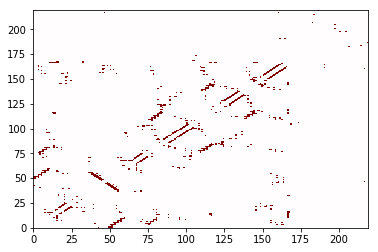

In [65]:
%%time
(fig, ax) = frame_contacts.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

The plotting function return the `matplotlib` `Figure` and `Axes` objects, which allow you to make more manipulations to them later. I'll show an example of that in the "Changing the defaults" section.

We can also plot the atom-atom contacts, although it takes a little time. The built-in plotting function is best if there are not many contacts (if the matrix is sparse). If there are lots of contacts, sometimes other approaches can plot more quickly. See an example in the "Changing the defaults" section.

CPU times: user 5.27 s, sys: 95.1 ms, total: 5.36 s
Wall time: 5.37 s


(<matplotlib.figure.Figure at 0x10c554750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10c56d590>)

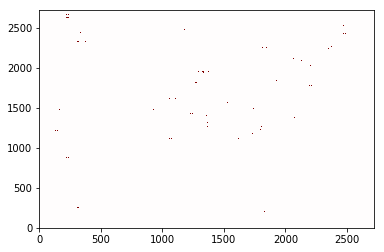

In [8]:
%%time
frame_contacts.atom_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

## Look at a trajectory: `ContactFrequency`

`ContactFrequency` finds the fraction of frames where each contact exists.

In [9]:
%%time
trajectory_contacts = ContactFrequency(traj[::100])

CPU times: user 4.89 s, sys: 19.1 ms, total: 4.91 s
Wall time: 4.92 s


In [10]:
# if you want to save this for later analysis
trajectory_contacts.save_to_file("traj_contacts.p")
# then load with ContactFrequency.from_file("traj_contacts.p")

CPU times: user 3.72 s, sys: 53.2 ms, total: 3.77 s
Wall time: 3.77 s


(<matplotlib.figure.Figure at 0x10cd9c290>,
 <matplotlib.axes._subplots.AxesSubplot at 0x111c7c450>)

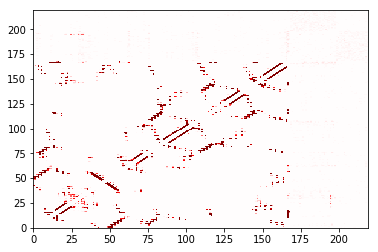

In [11]:
%%time
trajectory_contacts.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

## Compare two: `ContactDifference`

If you want to compare two frequencies, you can use the `ContactDifference` class (or the shortcut for it, which is to subtract a contact frequency/map from another.)

The example below will compare the trajectory to its first frame.

In [12]:
%%time
diff = trajectory_contacts - frame_contacts

CPU times: user 2.02 ms, sys: 1.06 ms, total: 3.08 ms
Wall time: 2.31 ms


A contact that appears in trajectory, but not in the frame, will be at +1 and will be shown in red below. A contact that appears in the frame, but not the trajectory, will be at -1 and will be shown in blue below. The values are the difference in the frequencies (of course, for a single frame, the frequency is always 0 or 1).

CPU times: user 3.54 s, sys: 62.1 ms, total: 3.6 s
Wall time: 3.61 s


(<matplotlib.figure.Figure at 0x1145e7050>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11557bbd0>)

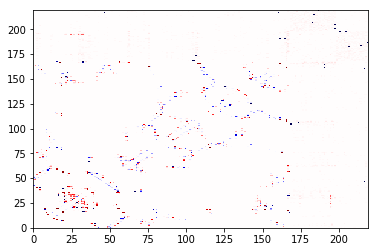

In [13]:
%%time
diff.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

You could have created the same object with:

```python
diff = ContactDifference(trajectory_contact, frame_contacts)
```

but the simple notation using `-` is much more straightforward. However, note that `ContactDifference` makes a difference between the *frequencies* in the two objects, not the absolute count. Otherwise the trajectory would swap the single frame, and there would be no blue in that picture!

### List the residue contacts that show the most difference

First we look at the frames that are much more important in the trajectory than the frame. Then we look at the frames that are more important in the frame than the trajectory.

The `.most_common()` method gives a list of the contact pairs and the frequency, sorted by frequency. See also `collections.Counter.most_common()` in the standard Python `collections` module.

Here we do this with the `ContactDifference` we created, although it works the same for `ContactFrequency` and `ContactMap` (with the single-frame contact map, the ordering is a bit nonsensical, since every entry is either 0 or 1).

In [14]:
%%time
# residue contact more important in trajectory than in frame (near +1)
diff.residue_contacts.most_common()[:10]

CPU times: user 6.17 ms, sys: 2.16 ms, total: 8.33 ms
Wall time: 6.88 ms


[([SER17, THR20], 0.9900990099009901),
 ([VAL81, ASN116], 0.9801980198019802),
 ([LEU19, VAL152], 0.9801980198019802),
 ([ALA18, GTP201], 0.9702970297029703),
 ([THR20, LYS16], 0.9603960396039604),
 ([ASP57, MG202], 0.9504950495049505),
 ([ILE163, GLU76], 0.9504950495049505),
 ([GLU162, HIS166], 0.9504950495049505),
 ([THR20, VAL8], 0.9405940594059405),
 ([ASP57, THR20], 0.9405940594059405)]

In [15]:
# residue contact more important in frame than in trajectory (near -1)
list(reversed(diff.residue_contacts.most_common()))[:10]
# alternate: diff.residue_contacts.most_common()[:-10:-1] # (thanks Sander!)

[([CL6864, ASP47], -0.9900990099009901),
 ([VAL29, ILE21], -0.9900990099009901),
 ([GLU162, NA6838], -0.9900990099009901),
 ([LYS165, NA6838], -0.9900990099009901),
 ([NA6816, SER106], -0.9900990099009901),
 ([ARG161, CL6864], -0.9900990099009901),
 ([CL6848, NA6845], -0.9900990099009901),
 ([GLU107, NA6821], -0.9900990099009901),
 ([CL6854, NA6830], -0.9900990099009901),
 ([ASP153, GLN22], -0.9801980198019802)]

### List the atoms contacts most common within a given residue contact

In [16]:
val81 = topology.residue(80)
asn116 = topology.residue(115)
print val81, asn116
gtp201 = topology.residue(166)

VAL81 ASN116


We extended the standard `.most_common()` to take an optional argument. When the argument is given, it will filter the output to only include the ones where that argument is part of the contact. For example, the following gives the residues most commonly in contact with GTP.

In [17]:
for contact in trajectory_contacts.residue_contacts.most_common(gtp201):
    if contact[1] > 0.1:
        print contact

([VAL14, GTP201], 1.0)
([GLY13, GTP201], 1.0)
([ALA146, GTP201], 1.0)
([SER145, GTP201], 1.0)
([GTP201, LEU120], 1.0)
([GTP201, GLY15], 1.0)
([GLY12, GTP201], 1.0)
([ALA11, GTP201], 1.0)
([GTP201, LYS16], 1.0)
([ASN116, GTP201], 1.0)
([LYS147, GTP201], 1.0)
([SER17, GTP201], 1.0)
([LYS117, GTP201], 1.0)
([GTP201, ASP119], 1.0)
([ALA18, GTP201], 0.9702970297029703)
([GTP201, GLU63], 0.5247524752475248)
([ASP57, GTP201], 0.42574257425742573)
([ASP33, GTP201], 0.22772277227722773)
([GTP201, THR144], 0.13861386138613863)


We can also find all the atoms, for all residue contacts, that are in contact with a given residue, and return that sorted by frequency.

In [18]:
diff.most_common_atoms_for_residue(gtp201)[:15]

[([ALA18-CB, GTP201-N7], 0.9702970297029703),
 ([GTP201-O2B, VAL14-CG1], 0.9702970297029703),
 ([GTP201-C8, ALA18-CB], 0.9702970297029703),
 ([SER17-N, GTP201-O2A], 0.9405940594059405),
 ([SER17-C, GTP201-O2A], 0.9405940594059405),
 ([GTP201-O2A, ALA18-CA], 0.9405940594059405),
 ([SER17-CA, GTP201-O2A], 0.9405940594059405),
 ([ALA18-N, GTP201-O2A], 0.9405940594059405),
 ([ALA18-CB, GTP201-O2A], 0.9405940594059405),
 ([SER17-N, GTP201-PB], 0.9306930693069307),
 ([GLY15-C, GTP201-O2A], 0.9306930693069307),
 ([GLY15-O, GTP201-O2A], 0.9108910891089109),
 ([LYS16-N, GTP201-O2A], 0.8811881188118812),
 ([GTP201-C2, LYS147-CB], 0.8514851485148515),
 ([GLY15-C, GTP201-PA], 0.8316831683168316)]

Finally, we can look at which atoms are most commonly in contact within a given residue contact pair.

In [19]:
trajectory_contacts.most_common_atoms_for_contact([val81, asn116])

[([ASN116-CB, VAL81-CG1], 0.9801980198019802),
 ([ASN116-CG, VAL81-CG1], 0.3465346534653465),
 ([VAL81-CG1, ASN116-ND2], 0.2079207920792079),
 ([VAL81-CG1, ASN116-N], 0.13861386138613863),
 ([VAL81-CG1, ASN116-CA], 0.019801980198019802)]

## Changing the defaults

This sections covers several options that you can modify to make the contact maps faster, and to focus on what you're most interested in.

The first three options change which atoms are included as possible contacts. The query atoms are the atoms which appear on the y-axis of the plot. The haystack atoms are those along the x-axis of the plot. In general, you should choose a query that is smaller than the haystack.

Both of these options take a list of atom index numbers. These are most easily created using MDTraj's atom selection language.

In [21]:
# the default selection is
default_selection = topology.select("not water and symbol != 'H'")
print len(default_selection)

1408


### Using a different query

In [22]:
switch1 = topology.select("resSeq 32 to 38 and symbol != 'H'")
switch2 = topology.select("resSeq 59 to 67 and symbol != 'H'")
gtp = topology.select("resname GTP and symbol != 'H'")
mg = topology.select("element Mg")
cations = topology.select("resname NA or resname MG")
sodium = topology.select("resname NA")

In [23]:
%%time
sw1_contacts = ContactFrequency(trajectory=traj[::100], query=switch1)

CPU times: user 1.97 s, sys: 10.4 ms, total: 1.98 s
Wall time: 1.98 s


(<matplotlib.figure.Figure at 0x10c3473d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f290a50>)

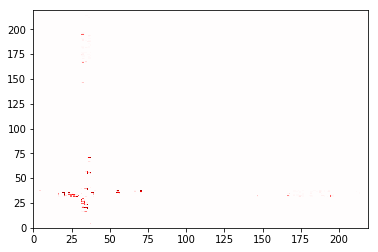

In [25]:
sw1_contacts.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

### Using a different haystack

Currently, changing the haystack has essentially no effect on the performance. However, I expect to change that in the  future (requires making some modifications to MDTraj).

In [26]:
%%time
cations_switch1 = ContactFrequency(trajectory=traj[::100], query=cations, haystack=switch1)

CPU times: user 1.88 s, sys: 12.9 ms, total: 1.89 s
Wall time: 1.9 s


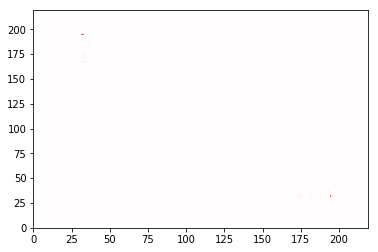

In [37]:
(fig, ax) = cations_switch1.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

Let's zoom in on that. To do this, we'll do a little MDTraj magic so that we can change the *atom* ID numbers, which are what go into our `cations` and `switch1` objects, into *residue* ID numbers (and we'll use Python `set`s to remove repeats):

In [44]:
def residue_for_atoms(atom_list, topology):
    return set([topology.atom(a).residue.index for a in atom_list])

In [64]:
switch1_residues = residue_for_atoms(switch1, traj.topology)
cation_residues = residue_for_atoms(cations, traj.topology)

Now we'll plot again, but we'll change the `x` and `y` axes so that we only see switch 1 along `x` and cations along `y`:

(167, 198)

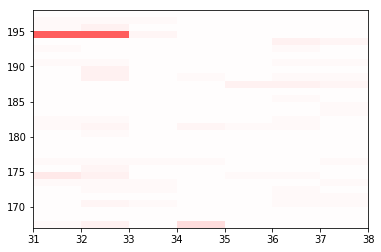

In [55]:
(fig, ax) = cations_switch1.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)
ax.set_xlim(min(switch1_residues), max(switch1_residues) + 1)
ax.set_ylim(min(cation_residues), max(cation_residues) + 1)

Here, of course, the boxes are much larger, and are long rectangles instead of squares. The box represents the residue number that is to its left and under it. So the most significant contacts here are between residues 31 and 32 and the ion listed as residue 194. Remember, these counts start at 0, even though the tradition in science (and the PDB) is to count from 1.

In [54]:
print cations_switch1.residue_contacts.counter[frozenset([31, 194])]
print cations_switch1.residue_contacts.counter[frozenset([32, 194])]

0.316831683168
0.316831683168


In [59]:
print traj.topology.residue(31)
print traj.topology.residue(32)
print traj.topology.residue(194)

TYR32
ASP33
NA6842


### Changing how many neighboring residues are ignored

By default, we ignore atoms from 2 residues on either side of the given residue (and in the same `chain`). This is easily changed. However, even when you say to ignore no neighbors, you still ignore the residue's interactions with itself.

Note: for non-protein contact, the `chain` is often poorly defined. In this example, the GTP and the Mg are listed sequentially in residue order, and therefore they are considered "neighbors" and their contacts are ignored.

In [29]:
%%time
ignore_none = ContactFrequency(trajectory=traj[::100], n_neighbors_ignored=0)

CPU times: user 6.92 s, sys: 66.3 ms, total: 6.99 s
Wall time: 6.99 s


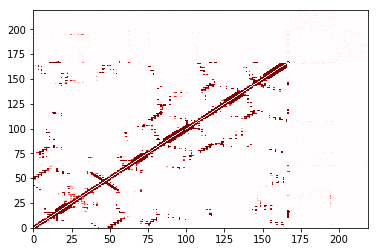

In [30]:
ignore_none.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

### Using a different cutoff

The size of the cutoff has a large effect on the performance. The default is (currently) 0.45nm.

In [31]:
%%time
large_cutoff = ContactFrequency(trajectory=traj[::100], cutoff=1.5)

CPU times: user 2min 36s, sys: 2.24 s, total: 2min 38s
Wall time: 2min 38s


The cost of the built-in plot function also depends strongly on the number of contacts that are made. It is designed to work well for sparse matrices; as the matrix gets less sparse, other approaches may be better. Here's an example:

CPU times: user 36.2 s, sys: 1.2 s, total: 37.4 s
Wall time: 37.6 s


(<matplotlib.figure.Figure at 0x1747925d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x176329750>)

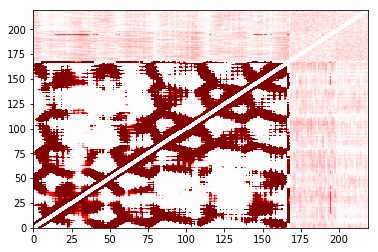

In [74]:
%%time
large_cutoff.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)

CPU times: user 7.43 s, sys: 85.4 ms, total: 7.51 s
Wall time: 7.53 s


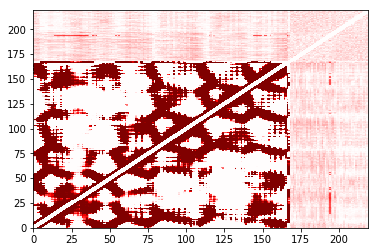

In [75]:
%%time
import matplotlib
cmap = matplotlib.pyplot.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

plot = matplotlib.pyplot.pcolor(large_cutoff.residue_contacts.df, cmap='seismic', vmin=-1, vmax=1)
plot.cmap.set_under(cmap(norm(0)))

In this case, using the `pandas.DataFrame` representation is faster. On the other hand, try using this approach on the atom-atom picture at the top! That will take a while.

You'll notice that these may not be pixel-perfect copies. This is because the number of pixels doesn't evenly divide into the number of residues. You can improve this by increasing the resolution (`dpi` in matplotlib) or the figure size. However, in both versions you can see the overall structure quite clearly.